In [ ]:
import pandas as pd
import io

Carichiamo i file di dati forniti su virutale.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test_data.csv to test_data (1).csv
Saving train_data.csv to train_data (1).csv
Saving val_data.csv to val_data (1).csv


In [ ]:
import io
train_df = pd.read_csv('train_data.csv')
val_df = pd.read_csv('val_data.csv')
test_df = pd.read_csv('test_data.csv')

Visioniamo i dati

In [ ]:
train_df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,8573,3,1,2,0,1,Can't get no money from me you silly hoe
1,21898,3,0,3,0,1,That was almost 10 years ago. I gave ALL them ...
2,17409,3,0,3,0,1,"RT @RakwonOGOD: Bitches tweeting ""last night &..."
3,21861,3,0,3,0,1,"That hoe out there, Fat Trel said it best."
4,8532,3,0,0,3,2,Can Charlie Crist pull one over on Rick Scott?...
...,...,...,...,...,...,...,...
17343,9729,6,0,6,0,1,Going hard bitch swear I'm on my job throw a q...
17344,14504,3,0,0,3,2,RT @AmPowerBlog: @velvethammer Parent in Phoen...
17345,20207,3,1,2,0,1,RT @nostalgic_mike: Aw y'all some hoes hating ...
17346,22962,3,0,0,3,2,Watch out #ned! #crc #worldcup2014 #puravida h...


Come si vede, per ogni sentenza ci sono 7 campi:


*   id: identificatore numerico
*   count: numero delle parole rilevanti ai fini della classificazione (questo è pari alla somma dei tre numeri successivi)
*   hate_speech: numero di associate con "hate speech"
*   offensive_language: numero di parole associate con "offensive language"
*   neither: numero di parole prese in considerazione ma non associate ale classi precedenti
*   class: la categoria a cui appartiene la sentenza (ground truth)
*   tweet: la sentenza da classificare









Ai fini del progetto potete decidere di utilizzare solo classe e tweet.
Siete inoltre liberi di effettuare il preprocessing che ritenete più opportuno e di utilizzare la forma di tokenizzazione ed eventuali word emebedding preallenati a vostra discrezione.


# Valutazione dei risultati

La metrica da utilizzare per valutare la prestazione del modello è la macro-f1. Si chiede inoltre di fornire la f1-accuracy per le singole classi e di visualizzare la confusion matrix. Per il calcolo della metrica f1 potete fare riferimentonumero al  classification_report fornito da scikit-learn https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html



Consegnate un unico notebook ben documentato.

GOOD WORK!

## Imports

In [ ]:
!pip install transformers

import tensorflow as tf
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from transformers import TFBertModel, BertTokenizer

## Data distribution and preprocessing

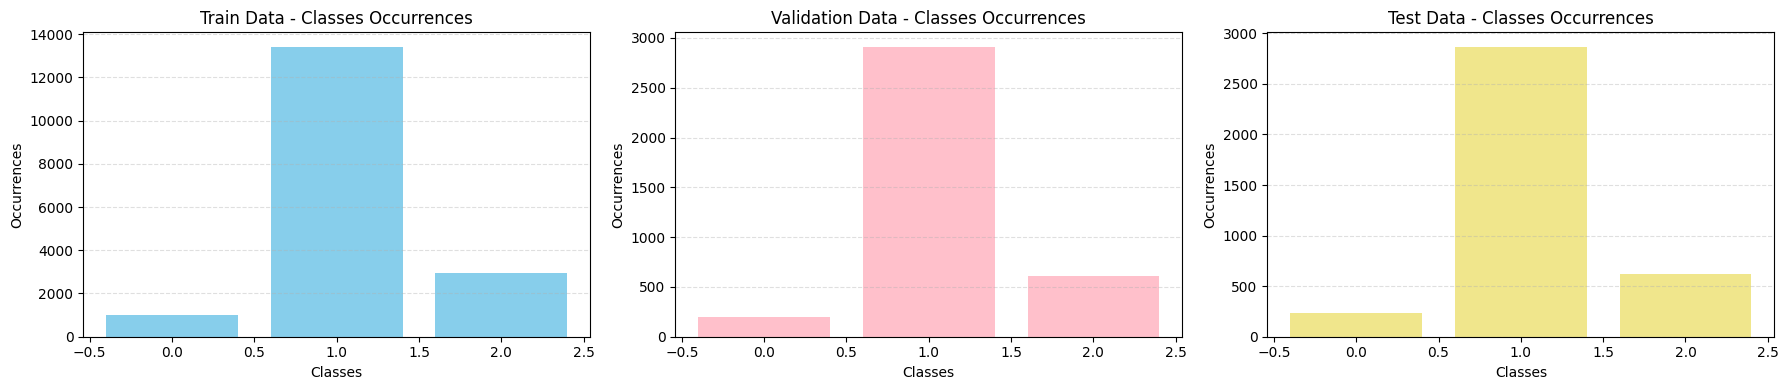

In [ ]:
train_classes = train_df['class']
train_class, train_occurrences = np.unique(train_classes, return_counts=True)

val_classes = val_df['class']
val_class, val_occurrences  = np.unique(val_classes, return_counts=True)

test_classes = test_df['class']
test_class, test_occurrences  = np.unique(test_classes, return_counts=True)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

# Graph 1 - Train Data
ax1.bar(train_class, train_occurrences, color='skyblue')
ax1.set_xlabel('Classes')
ax1.set_ylabel('Occurrences')
ax1.set_title('Train Data - Classes Occurrences')
ax1.grid(True, axis='y', linestyle='--', alpha=0.4)

# Graph 2 - Validation Data
ax2.bar(val_class, val_occurrences, color='pink')
ax2.set_xlabel('Classes')
ax2.set_ylabel('Occurrences')
ax2.set_title('Validation Data - Classes Occurrences')
ax2.grid(True, axis='y', linestyle='--', alpha=0.4)

# Graph 3 - Test Data
ax3.bar(test_class, test_occurrences, color='khaki')
ax3.set_xlabel('Classes')
ax3.set_ylabel('Occurrences')
ax3.set_title('Test Data - Classes Occurrences')
ax3.grid(True, axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


In [ ]:
# Data preprocessing
def preprocess_text(text):
  text = text.lower()
  text = re.sub(r'@\S+', '', text)
  text = re.sub(r'&\S+;', '', text)
  text = re.sub(r'[^a-zA-Z\s]', '', text)
  text = re.sub(r'https?://\S+', '', text)
  text = re.sub(r'#\S+', '', text)
  text = re.sub(r'rt', '', text)
  text = re.sub(r'\s+', ' ', text).strip()
  return text

pd.set_option('display.max_colwidth', 100)
print("\nBEFORE PREPROCESSING")
print(train_df["tweet"][:5].values)

train_tweets = train_df['tweet'].apply(lambda x: preprocess_text(x))
val_tweets = val_df['tweet'].apply(lambda x: preprocess_text(x))
test_tweets = test_df['tweet'].apply(lambda x: preprocess_text(x))

print("\nAFTER PREPROCESSING")
print(train_tweets[:5].values)

# One hot encoding
num_classes = 3

categorical_train_class = keras.utils.to_categorical(train_classes.values, num_classes)
categorical_validation_class = keras.utils.to_categorical(val_classes.values, num_classes)
categorical_test_class = keras.utils.to_categorical(test_classes.values, num_classes)
#print(categorical_train_class)


BEFORE PREPROCESSING
["Can't get no money from me you silly hoe"
 'That was almost 10 years ago. I gave ALL them bitches away... or they were stolen...'
 'RT @RakwonOGOD: Bitches tweeting "last night &gt;&gt;" like they did something special except be hoes'
 'That hoe out there, Fat Trel said it best.'
 'Can Charlie Crist pull one over on Rick Scott? Well he did pull one over on #floridaprimary dems tonite. #TPOT #Election2014']

AFTER PREPROCESSING
['cant get no money from me you silly hoe'
 'that was almost years ago i gave all them bitches away or they were stolen'
 'bitches tweeting last night like they did something special except be hoes'
 'that hoe out there fat trel said it best'
 'can charlie crist pull one over on rick scott well he did pull one over on floridaprimary dems tonite tpot election']


# Model definition and training

In [ ]:
# Loading Bert Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenization(data):
  input_ids = []
  attention_masks = []
  for tweet in data:
    encoded_dict = tokenizer.encode_plus(
                        tweet,
                        add_special_tokens=True,
                        max_length=64,
                        padding='max_length',
                        return_attention_mask=True,
                        return_tensors='tf',
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

  input_ids = tf.concat(input_ids, axis=0)
  attention_masks = tf.concat(attention_masks, axis=0)
  return input_ids, attention_masks

# Tokenization training, validation and test dataset
train_input_ids, train_attention_masks = tokenization(train_tweets)
val_input_ids, val_attention_masks = tokenization(val_tweets)
test_input_ids, test_attention_masks = tokenization(test_tweets)

In [ ]:
# Model layers
input_layer = Input(shape=(64,), dtype=tf.int32, name="input_ids")
mask_layer = Input(shape=(64,), dtype=tf.int32, name="attention_mask")

bert_model = TFBertModel.from_pretrained('bert-base-uncased', trainable=True)
bert_output = bert_model([input_layer, mask_layer])[0]

dense_layer = Dense(256, activation='relu')(bert_output)
flat_output = Flatten()(dense_layer)
dropout_output = Dropout(0.3)(flat_output)

output_layer = Dense(3, activation='softmax')(dropout_output)

# Model creation
model = Model(inputs=[input_layer, mask_layer], outputs=output_layer)

# Compiling model
# optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
optimizer = RMSprop(learning_rate=0.0001, name="RMSprop")
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Early stop and checkpoint definitions
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 64)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 64)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 64,                                            

## Training

In [ ]:
model_history = model.fit([train_input_ids, train_attention_masks], categorical_train_class, batch_size=32, epochs=10, validation_data=([val_input_ids, val_attention_masks], categorical_validation_class), callbacks=[early_stopping, model_checkpoint])

Epoch 1/10


543/543 [==============================] - 278s 439ms/step - loss: 0.3183 - accuracy: 0.8909 - val_loss: 0.3383 - val_accuracy: 0.8954
Epoch 2/10
543/543 [==============================] - 241s 443ms/step - loss: 0.2307 - accuracy: 0.9202 - val_loss: 0.2809 - val_accuracy: 0.9029
Epoch 3/10
543/543 [==============================] - 240s 441ms/step - loss: 0.1857 - accuracy: 0.9346 - val_loss: 0.3527 - val_accuracy: 0.9056
Epoch 4/10
543/543 [==============================] - 240s 442ms/step - loss: 0.1430 - accuracy: 0.9481 - val_loss: 0.4525 - val_accuracy: 0.9118


# Results

In [ ]:
# Model evaluation
loss, accuracy = model.evaluate([test_input_ids, test_attention_masks], categorical_test_class)
print("Test loss:\t{:.5f}".format(loss))
print("Test accuracy:\t{:.2f}%".format(accuracy * 100))

# Model prediction
y_pred = model.predict([test_input_ids, test_attention_masks])

num_pred_classes = np.argmax(y_pred, axis=1)
num_test_class= np.argmax(categorical_test_class, axis=1)

classification_rep = classification_report(num_test_class, num_pred_classes, zero_division=0)
confusion_mat = confusion_matrix(num_test_class, num_pred_classes)

print("\nClassification report:\n", classification_rep)
print("\nConfusion Matrix:\n", confusion_mat)
print("\nMacro f1:", f1_score(num_test_class, num_pred_classes, average='macro'))

117/117 [==============================] - 19s 159ms/step - loss: 0.2768 - accuracy: 0.9072
Test loss:	0.27678
Test accuracy:	90.72%
117/117 [==============================] - 20s 142ms/step

Classification report:
               precision    recall  f1-score   support

           0       0.48      0.49      0.48       230
           1       0.96      0.93      0.94      2867
           2       0.85      0.96      0.90       620

    accuracy                           0.91      3717
   macro avg       0.76      0.79      0.78      3717
weighted avg       0.91      0.91      0.91      3717


Confusion Matrix:
 [[ 112   97   21]
 [ 117 2667   83]
 [   3   24  593]]

Macro f1: 0.7762053567096375


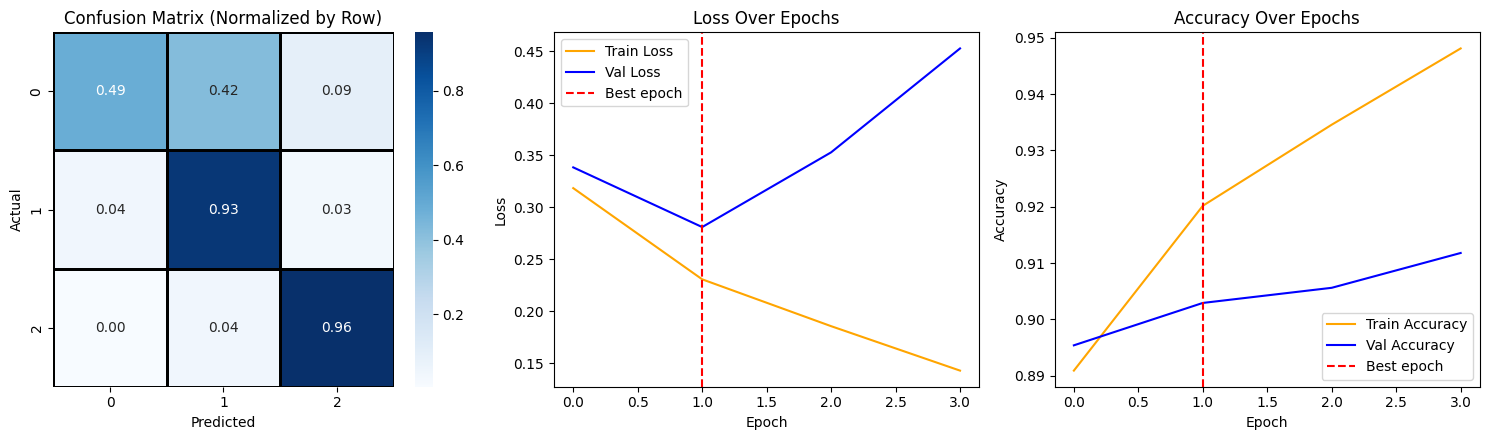

In [ ]:
plt.figure(figsize=(15, 4.5))

# Confusion matrix
plt.subplot(1, 3, 1)
row_sums = confusion_mat.sum(axis=1, keepdims=True)
normalized_cm = confusion_mat / row_sums
sns.heatmap(normalized_cm, annot=True, cmap="Blues", fmt=".2f", linewidths=1, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Normalized by Row)')

# Loss
plt.subplot(1, 3, 2)
plt.plot(model_history.epoch, model_history.history['loss'], color='orange')
plt.plot(model_history.epoch, model_history.history['val_loss'], color='blue')
plt.axvline(x=early_stopping.best_epoch, color='r', linestyle='--')
plt.legend(['Train Loss', 'Val Loss', 'Best epoch'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')

# Accuracy
plt.subplot(1, 3, 3)
plt.plot(model_history.epoch, model_history.history['accuracy'], color='orange')
plt.plot(model_history.epoch, model_history.history['val_accuracy'], color='blue')
plt.axvline(x=early_stopping.best_epoch, color='r', linestyle='--')
plt.legend(['Train Accuracy', 'Val Accuracy', 'Best epoch'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')

plt.tight_layout()
plt.show()

# Feature Selection and Model Training Approach

**Scelta delle features**:


> Il dubbio iniziale è stato quello in cui scegliere se utilizzare solo i tweet e la classe di appartenenza o se utilizzare anche le altre features come il numero di parole `hate_speech`, `offensive_language` e `neither`.

> Ho provato a implementare un modello che come output avesse il numero di parole delle varie classi così da aggiungere poi una parte algoritmica che semplicemente, prendendo il valore più alto definisse la classe di appartenenza del tweet. Il modello non ha portato ai risultati sperati, per questo ho abbandonato l'idea e tentato di sviluppare un modello che imparasse a definire la classe **direttamente dal tweet**, senza passare dal numero di parole. Questo approccio è stato sicuramente più semplice da seguire e comunque ha portato a risultati non indifferenti.



---

**Pretrained Models**:
> Sviluppando il modello qui sopra, ho effettuato vari tentativi per cercare dii valutare diverse strategie di formattazione del testo in token. In particolare, ho provato ad utilizzare 3 strategie diverse: l'uso di una ***matrice di embedding randomica***, l'utilizzo di ***Glove***, e l'utilizzo di ***Bert***. Tuttavia, l'implementazione di Bert ha fornito risultati  superiori rispetto alle altre due opzioni, per questo la scelta di mantenere Bert.



> Una volta scelto il modello ***Bert***, ho provato a "congelarlo" e addestrare la mia rete soltanto nei layer aggiunti da me e in seguito ad effettuare del fine-tuning, ma questo ha portato a scarsi risultati. Provando invece a lasciare `trainable=True` nel modello preaddestrato, il training è andato decisamente meglio rispetto al primo tentativo.



---

**Optimizers**:
> Una volta scelto il modello, ho cercato vari optimizer che si potessero adattare al mio problema, in particolare ho provato con ***Adam***, ***SGD*** e ***RMSprop***, cambiandone i parametri, in particolare il `learning_rate`. Nonostante comunque le loro prestazioni molto simili, RMSprop si è risultato leggermente superiore per quanto riguarda i risultati, motivo per cui ho deciso di utilizzare questo optimizer. Un learning rate troppo alto (0.01) portava il modello in una situazione di stallo in cui non riusciva più a migliorare, quindi ho optato per qualcosa di più piccolo (0.0001)

---

**Problemi**:


* Uno dei problemi più importanti che ho avuto è stato quello in cui il modello aveva difficoltà a distinguere la classe 0 dalle altre, come mostrato nell'immagine qui sotto. Un tasso di learning rate minore e l'utilizzo di Bert invece di Glove hanno portato a miglioramenti decisivi per questo problema.
> 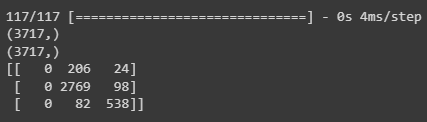



*   Un altro problema risolto abbasstanza velocemente è stato quello dell'overfitting. L'introduzione di una funzione di `early_stopping` (insieme a una di `checkpoint` che prevede a recuperare l'epoca migliore dopo che il modello si è fermato tramite early_stopping) insieme ad un layer di dropout hanno notevolmente contribuito alla risoluzione di questo problema.
---